# The deep deterministic policy gradient (DDPG)
 Is a model-free, online, off-policy reinforcement learning method.

 DDPG uses four neural networks: a Q network, a deterministic policy network, a target Q network, and a target policy network.

 The Q network and policy network is very much like simple Advantage Actor-Critic, but in DDPG, the Actor directly maps states to actions (the output of the network directly the output) instead of outputting the probability distribution across a discrete action space.

 The target networks are time-delayed copies of their original networks that slowly track the learned networks.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
import gym
import matplotlib.pyplot as plt

In [ ]:
# Define the Actor Network architecture
class Actor(nn.Module):
    def __init__(self, input_size, output_size, num_hidden=64):
        super(Actor, self).__init__()

        self.network = torch.nn.Sequential(
            nn.Linear(input_size, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, output_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
# Define the Critic Network architecture
class Critic(nn.Module):
    def __init__(self, input_size, output_size, num_hidden=64):
        super(Critic, self).__init__()

        self.network = torch.nn.Sequential(
            nn.Linear(input_size, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, state, action): # Use action-value function
        x = torch.cat([state, action], dim=-1)
        return self.network(x)

In [ ]:
# Define the Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

### Deep Deterministic Policy Gradient algorithm

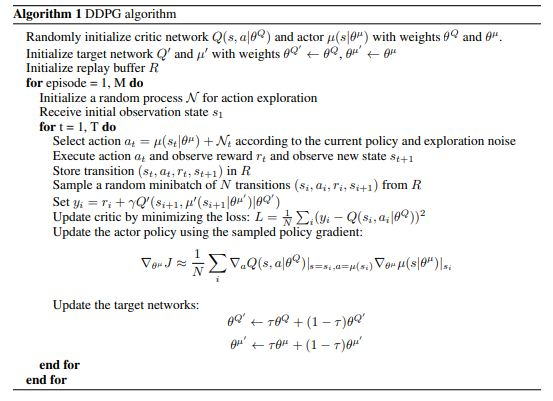

In [ ]:
class DDPG_Agent:
    def __init__(self, env, hidden_size=64, batch_size=64, actor_lr=1e-3, critic_lr=1e-3, gamma=0.99, tau=1e-2, max_replay_buffer_size=10000):
      input_size = env.observation_space.shape[0]
      output_size = env.action_space.shape[0]

      # Network
      self.actor = Actor(input_size, output_size, hidden_size)
      self.actor_target = Actor(input_size, output_size, hidden_size)
      self.critic = Critic(input_size+output_size, output_size, hidden_size)
      self.critic_target = Critic(input_size+output_size, output_size, hidden_size)

      self.tau = 1.0
      self.target_soft_update()

      # Define hyperparameters
      self.batch_size = batch_size
      self.gamma = gamma
      self.tau = tau

      self.replay_buffer = ReplayBuffer(capacity=max_replay_buffer_size)
      self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
      self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
      self.loss_fn = nn.MSELoss()


    # Soft update of target network
    def target_soft_update(self):
      for target_params, params in zip(self.actor_target.parameters(), self.actor.parameters()):
          target_params.data.copy_(self.tau * params.data + (1.0 - self.tau) * target_params.data)

      for target_params, params in zip(self.critic_target.parameters(), self.critic.parameters()):
          target_params.data.copy_(self.tau * params.data + (1.0 - self.tau) * target_params.data)


    def get_action(self, state):
      state_tensor = torch.FloatTensor(state).unsqueeze(0)
      action_tensor = self.actor(state_tensor).detach()
      action = action_tensor.numpy()[0]
      return action


    def update(self):
      # Sample a random minibatch from the replay buffer and update the DDPG
      states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

      state_tensors = torch.FloatTensor(states)
      action_tensors = torch.FloatTensor(actions)
      reward_tensors = torch.FloatTensor(rewards).unsqueeze(1)
      next_state_tensors = torch.FloatTensor(next_states)
      done_tensors = torch.FloatTensor(dones).unsqueeze(1)

      # Critic loss
      q_values = self.critic(state_tensors, action_tensors)

      with torch.no_grad():
        next_actions = self.actor_target(next_state_tensors)
        next_q_values = self.critic_target(next_state_tensors, next_actions)
        target_q_values = reward_tensors + self.gamma * next_q_values * (1 - done_tensors)

      critic_loss = self.loss_fn(q_values, target_q_values)

      # Actor loss
      predicted_actions = self.actor(state_tensors)
      actor_policy_loss = -self.critic(state_tensors, predicted_actions).mean()

      self.actor_optimizer.zero_grad()
      actor_policy_loss.backward()
      self.actor_optimizer.step()

      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()

      self.target_soft_update()


### Exploration:

In Reinforcement learning for continuous action spaces, exploration is done via adding noise to the action itself. DDPG use Ornstein-Uhlenbeck Process to generates noise that is correlated with the previous noise, as to prevent the noise from canceling out or “freezing” the overall dynamics.

In [ ]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 0, Total reward: -1666.9661907606771
Episode 100, Total reward: -616.5128739109135
Episode 200, Total reward: -381.9870212426695
Episode 300, Total reward: -737.3926553530391
Episode 400, Total reward: -496.6352004848758
Episode 500, Total reward: -835.7271918880251
Episode 600, Total reward: -373.2812866633598
Episode 700, Total reward: -613.5873093993063
Episode 800, Total reward: -491.4332569412998
Episode 900, Total reward: -494.44420376291765


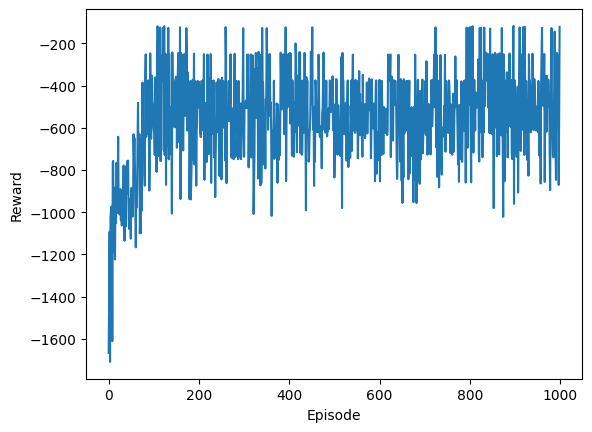

In [ ]:
# Initialize the environment and the agent
env_id = 'Pendulum-v1'
env = gym.make(env_id, render_mode='rgb_array')
agent = DDPG_Agent(env)
noise = OUNoise(env.action_space)

# Training loop
num_episodes = 1000
max_steps = 1000

total_rewards = []
for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0

    for step in range(max_steps):
        # Action selection by adding Ornstein-Uhlenbeck noise
        action = agent.get_action(state)
        action = noise.get_action(action, step)

        next_state, reward, done, _ = env.step(action)
        episode_reward += reward

        # Store the transition in the replay buffer
        agent.replay_buffer.push((state, action, reward, next_state, done))

        state = next_state

        # Sample a random minibatch from the replay buffer and update the DDPG
        if len(agent.replay_buffer.buffer) >= agent.batch_size:
          agent.update()

        if done: break

    if episode % 100 == 0:
        print(f"Episode {episode}, Total reward: {episode_reward}")

    total_rewards.append(episode_reward)

plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

## Evaluation

In [ ]:
def evaluate_model(model, env, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)

            with torch.no_grad():
                action = model(state_tensor).squeeze(0).numpy()

            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            state = next_state

        total_rewards.append(episode_reward)

    average_reward = sum(total_rewards) / num_episodes
    return average_reward

In [ ]:
num_episodes = 10
average_reward = evaluate_model(agent.actor, env, num_episodes)
print(f"Average reward over {num_episodes} episodes: {average_reward}")

Average reward over 10 episodes: -144.91992490674468


In [ ]:
!pip install pyvirtualdisplay
!apt install xvfb -y
!pip install ffmpeg
!pip install imageio-ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 9 not upgraded.
Need to get 7,812 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archive

In [ ]:
from pyvirtualdisplay import Display
from gym.wrappers.monitoring.video_recorder import VideoRecorder

display = Display(visible=False, size=(1400, 900))
_ = display.start()

video_path = f"./video/{env_id}.mp4"
video_recorder = VideoRecorder(env, video_path, enabled=True)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


In [ ]:
def record_video(model, env):
    state = env.reset()
    done = False

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
          action = model(state_tensor).squeeze(0).numpy()
        next_state, reward, done, _ = env.step(action)
        state = next_state

        video_recorder.capture_frame()

    video_recorder.close()

record_video(agent.actor, env)

In [ ]:
from base64 import b64encode

def render_mp4(videopath: str) -> str:
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from IPython.display import HTML

html = render_mp4(video_path)
HTML(html)